In [2]:
#for dark theme
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import csv

In [4]:
#read in train and test data
dfTrain = pd.read_csv('train.csv')
finalTest = pd.read_csv('test.csv')

In [5]:
#Since the data are images describe by pixels from 1 to pixel 783, need to plot the images out instead of showing the rows with pandas 
dfTrain.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#make a target dataframe from the label of train data
target = dfTrain['label']
dfTrain.drop('label', axis=1, inplace= True)

C:\Users\chiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


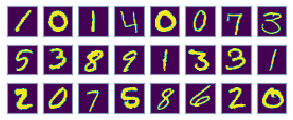

In [7]:
plt.figure(figsize=(5,2))
for i in range(0,24):
    plt.subplot(3,8,i+1)
    digitImage = dfTrain.iloc[i].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(digitImage, interpolation = "nearest")
    plt.xticks([])
    plt.yticks([])

### Split the data into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dfTrain, target, train_size=0.75, random_state=123)

C:\Users\chiu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
#For checking the columns in each 2d array
X_train.head(3)
X_test.head(3)
y_train.head(3)
y_test.head(3)

30261    2
28092    2
1        0
Name: label, dtype: int64

### Decomposition with PCA into 2 dimensions 

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
#Since the features are equally represented (pixels), I dont need scale/normalize the data. (am I right?)

In [12]:
#start the PCA process
pca = PCA(n_components=2)
pca.fit(X_train)
#transform the columns
pcs = pca.transform(X_train)
#Put the pc into a dataframe
pcDf = pd.DataFrame(pcs, columns=['pc1','pc2'])
pcDf.head()

,pc1,pc2
0,-205.068601,620.569056
1,-248.222851,870.766337
2,700.288875,530.732616
3,-280.001610,799.114114
4,206.584953,288.760592


Text(0,0.5,'pc2')

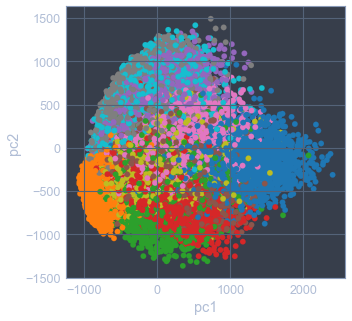

In [13]:
#Scatter plot for the labels with 10 colors
plt.figure(figsize=(5,5))
plt.scatter(x= pcDf.pc1, y= pcDf.pc2, c=y_train, cmap ='tab10', marker = 'o') #This is the best color map I found for the 10 digits labels
plt.xlabel("pc1")
plt.ylabel("pc2")
#PCA separates the digits into 10 different clusters
#Many of the points are overlapped on this 2 dimension graph

In [14]:
#Proceed to use 2 dimension pca to train a kNN model
pca = PCA(n_components=2)
pca.fit(X_train)
#transform the columns
pcs = pca.transform(X_train)
#Use PCA for KNN
tran_train = pca.transform(X_train)
tran_test = pca.transform(X_test)

# n=10 digits from 0-9
# p=2 the standard Eucldean distance metric aka L2
knn = KNeighborsClassifier(n_neighbors= 10, p=2)

knn.fit(X = tran_train, y= y_train) #Train the model
testResults = knn.predict(tran_test) #Use the model for test data

#Look at the accuracy of the model for test data 
accuracy_score(y_test, testResults)

0.4400952380952381

### Find a optimal PCA dimension

In [42]:
#Make a list of # of pc
n_pc = list(np.arange(2,21,2))
n_pc.extend([30,40,50,70,100])

In [41]:
#Make a list of k
k_list = list(np.arange(5,20,2))

In [37]:
acc = []
for i in n_pc:
    acc_pc =[]
    for k in k_list:
        pca = PCA(n_components=i)
        pca.fit(X_train)
        pcs = pca.transform(X_train)
        tran_train = pca.transform(X_train)
        tran_test = pca.transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors= k, p= 2)
        
        knn.fit(X = tran_train, y= y_train) #Train the model with redefined pca
        testResults = knn.predict(tran_test) #Test the model again
        
        acc_pc.append(accuracy_score(y_test, testResults))
    #Store accuracy score with highest k in the list
    acc.append(max(acc_pc))

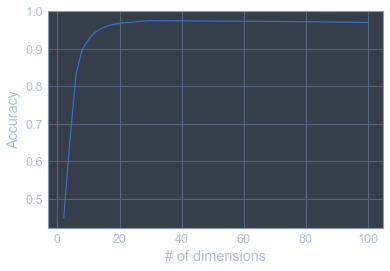

In [40]:
#from the graph we can the accuracy reach diminishing returns around 30 PCs.
plt.plot(n_pc, acc)
plt.xlabel('# of dimensions')
plt.ylabel('Accuracy')
plt.show()

### KNN model using 30 PC

In [52]:
#Use the same code to make a knn model with 30 PCs
pca = PCA(n_components=30)
pca.fit(X_train)

#Transform columns
pcs = pca.transform(X_train)
tran_train = pca.transform(X_train)
tran_test = pca.transform(finalTest)

knn = KNeighborsClassifier(n_neighbors= 10, p=2)

knn.fit(X = tran_train, y= y_train) 
finalResults = knn.predict(tran_test)

### Write result to csv

In [68]:
finalRes = {'ImageId': list(np.arange(1,len(finalResults)+1)) ,'Label': finalResults }
df = pd.DataFrame(data = finalRes)
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [70]:
df.to_csv('pca_knn_submission.csv', index =False)